## Mitosis Exploration/Visualization

Here we attempt to create a dataset of mitosis patches and equal numbers of non-mitotis patches, and visualize results, classifications, and statistics for this dataset using matplotlib and scikit-learn.

In [76]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from urllib import urlretrieve
import cPickle as pickle
import os
import glob
import sys
import gzip

import numpy as np
import theano

from keras.utils import np_utils
import sklearn
import sknn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from PIL import Image
import codecs

import csv
import xlrd

In [44]:
# Constants
SIZE = 2084
PATCH_SIZE = 54
NUM = 20
VAL_NUM = 11
PATCH_NUM = 2000*NUM
VAL_PATCH_NUM = 144
split = 0.7
TRAIN = "train/A0";
TEST = "test/A0";
retrain = True

We set NUM to 20 initially to indicate we will read 20 images and look at those patches first.

In [39]:
# creating and storing training + testing data
trainImg = np.zeros((PATCH_NUM, 3, PATCH_SIZE, PATCH_SIZE))
trainVal = np.zeros((PATCH_NUM))
cnt = 0
cnt2 = 0

for n in range(1, 5):
	for m in range(0, 9):
		print cnt,
		if cnt >= NUM: 
			break
		imageFile = TRAIN + `n` + "_0" + `m` + ".bmp"
		annotFile = TRAIN + `n` + "_0" + `m` + ".csv"
		try:
			img = Image.open(imageFile);
			pix = img.load()
		except:
			continue
		#img.resize((SIZE, SIZE))


		#for i in range(0, SIZE):
		#	for j in range(0, SIZE):
		#		trainImg[cnt, 0, i, j] = float(pix[i, j][1])/255

		csvReader = csv.reader(codecs.open(annotFile, 'rU', 'utf-8'))
		tot = 0
		imgMask = np.zeros((SIZE, SIZE));
		for row in csvReader:
			minx, miny, maxx, maxy = (SIZE, SIZE, 0, 0)
			for i in range(0, len(row)/2):
				tot = tot + 1
				xv, yv = (int(row[2*i]), int(row[2*i+1]))
				imgMask[xv, yv] = 1
				minx = min(minx, xv)
				maxx = max(maxx, xv)
				miny = min(miny, yv)
				maxy = max(maxy, yv)


			if minx + PATCH_SIZE >= SIZE or miny + PATCH_SIZE >= SIZE:
				continue;
			if minx + PATCH_SIZE <= maxx or miny + PATCH_SIZE <= maxy:
				print "Mitoses too big!"
				print minx,maxx,miny, maxy
				continue
			print ("here")
			for di in range(0, PATCH_SIZE):
				for dj in range(0, PATCH_SIZE):
					trainImg[cnt2, 0, di, dj] = float(pix[minx + di, miny + dj][0])/255
					trainImg[cnt2, 1, di, dj] = float(pix[minx + di, miny + dj][1])/255
					trainImg[cnt2, 2, di, dj] = float(pix[minx + di, miny + dj][2])/255
			trainVal[cnt2] = 1
			cnt2 = cnt2 + 1
			

                
			#if minx - PATCH_SIZE <= 0 or miny - PATCH_SIZE <= 0:
			#	continue
			#if maxx - PATCH_SIZE <= 0 or maxy - PATCH_SIZE <= 0:
			#	continue
			# shows image
			#img2 = img.crop((minx, miny, minx + PATCH_SIZE, miny + PATCH_SIZE))
			#print "Showing image"
			#img2.show();
			

			#puts image into train data
		for i in range(0, SIZE/PATCH_SIZE - 1):
			i = i * PATCH_SIZE
			for j in range(0, SIZE/PATCH_SIZE - 1):
				j = j * PATCH_SIZE
				for di in range(0, PATCH_SIZE):
					for dj in range(0, PATCH_SIZE):
						trainImg[cnt2, 0, di, dj] = float(pix[i + di, j + dj][0])/255
						trainImg[cnt2, 1, di, dj] = float(pix[i + di, j + dj][1])/255
						trainImg[cnt2, 2, di, dj] = float(pix[i + di, j + dj][2])/255

						if imgMask[i + di, j + dj] == 1:
							trainVal[cnt2] = 1
				
				if trainVal[cnt2] == 1:
					#we don't want to include this PATCH: we've  already included it b4.
					trainVal[cnt2] = 0
				else:
					cnt2 = cnt2 + 1
				if cnt2 % 1000 == 0:
					print cnt2
		cnt = cnt + 1

trainImg = trainImg[0:cnt2]
trainVal = trainVal[0:cnt2]

from sklearn.utils import shuffle
trainImg, trainVal = shuffle(trainImg, trainVal, random_state=5)
#print "Train image patches:",trainImg
print "Train targets:",trainVal
print "Data number",cnt2

#Save data

np.save("trainImg_imbalance.npy", trainImg)
np.save("trainVal_imbalance.npy", trainVal)

0 here
here
here
here
here
here
Mitoses too big!
419 482 1955 2014
here
1000
1 here
here
here
here
2000
2 here
Mitoses too big!
1966 2016 1580 1647
here
here
Mitoses too big!
1719 1774 533 581
here
here
here
here
here
here
3000
4000
3 here
here
here
here
here
here
here
here
here
here
here
5000
4 4 here
here
here
Mitoses too big!
1466 1517 628 684
here
here
6000
5 5 here
here
here
here
here
here
here
here
here
7000
8000
6 here
here
here
here
here
here
here
9000
7 7 7 here
here
here
here
10000
8 8 here
here
here
here
11000
12000
9 here
here
here
13000
10 here
here
here
14000
11 11 here
here
here
here
here
here
15000
16000
12 12 12 here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
17000
13 here
here
here
here
here
here
here
here
here
here
here
18000
19000
14 14 here
here
here
here
here
here
here
here
here
here
here
here
20000
15 here
here
here
here
here
here
here
here
here
here
here
21000
16 here
here
here
here
here
here
here
here
22000
23000
17 here
her

In [54]:
# Alternatively, load data from save
trainImg = np.load("trainImg_imbalance.npy")
trainVal = np.load("trainVal_imbalance.npy")

The rough algorithm used here is: find all mitosis patches by centering a window on the mitosis patches.

Now we have all the mitosis data. Let's visualize a single patch using matplotlib.

In [55]:
def rgb(patch):
    return np.swapaxes(np.swapaxes(patch, 0, 1) , 1, 2);

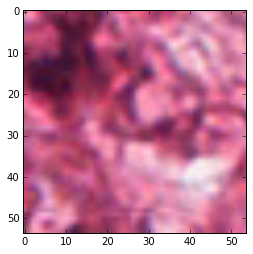

In [56]:
%matplotlib inline
plt.imshow(rgb(trainImg[0]))
plt.show()

That was apparently a normal patch. Let's find all mitosis patches and display one. Also, we can create an even number of non-mitotic patches, to make an initially balanced dataset of mitotic and non-mitotic patches.

In [57]:
from sklearn.utils import shuffle

mitosisSet = []
for i in range(0, len(trainVal)):
    if trainVal[i] == 1:
        mitosisSet.append(i)

normalSet = []
for i in range(0, len(trainVal)):
    if trainVal[i] == 0 and len(normalSet) < len(mitosisSet):
        normalSet.append(i)
fullSet = normalSet + mitosisSet
fullSet = shuffle(fullSet)
print fullSet

[149, 18031, 125, 20816, 95, 17778, 7721, 147, 38, 3186, 13169, 12542, 12, 120, 3, 1829, 97, 2244, 62, 23750, 132, 22929, 105, 81, 9, 58, 15281, 26761, 22527, 7, 8, 145, 54, 23431, 63, 23501, 16008, 28, 25354, 51, 29, 8138, 87, 10908, 130, 88, 14, 104, 136, 84, 82, 24291, 12086, 3141, 101, 779, 110, 66, 4, 8317, 52, 11525, 115, 4085, 15506, 14608, 127, 11897, 116, 24916, 6442, 24, 11938, 142, 10, 19, 18215, 21297, 13, 99, 42, 7252, 9634, 23361, 7843, 21082, 3467, 186, 20017, 41, 79, 21007, 19664, 27201, 22634, 96, 74, 9507, 91, 48, 137, 122, 15, 70, 59, 21772, 8235, 89, 103, 4657, 23672, 6752, 19626, 128, 21922, 1696, 4027, 20122, 47, 31, 13778, 11588, 19789, 65, 69, 1634, 126, 11800, 119, 12312, 53, 1630, 23, 61, 17132, 24535, 26636, 50, 5823, 13857, 24033, 20541, 18, 135, 33, 12223, 49, 80, 2514, 109, 20837, 76, 12085, 108, 11672, 7472, 8191, 16826, 112, 37, 6867, 67, 143, 12319, 21444, 16124, 35, 4131, 19375, 15322, 26971, 55, 57, 22461, 7836, 17098, 19640, 9642, 2478, 124, 22370, 7

7429


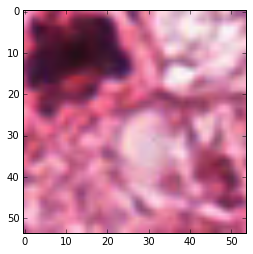

In [58]:
import random

mitosis = random.choice(mitosisSet)
print mitosis

%matplotlib inline
plt.imshow(rgb(trainImg[mitosis]))
plt.show()

Let's visualize and compute some very simple image features for this random image with scikit-image! First we will need to make the image gray and segment it.

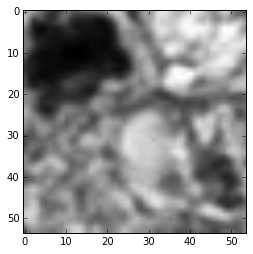

In [59]:
from skimage import data
from skimage.color import rgb2gray

img = rgb(trainImg[mitosis])
img_gray = rgb2gray(img)

%matplotlib inline

plt.imshow(img_gray, cmap = "gray")
plt.show()

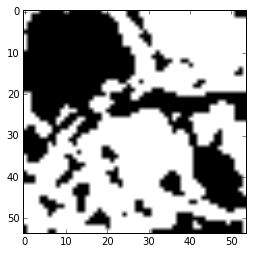

In [60]:
from skimage.filters import threshold_otsu

thresh = threshold_otsu(img_gray)
img_otsu = img_gray > thresh

%matplotlib inline

plt.imshow(img_otsu, cmap = "gray")
plt.show()

We can now get simple "features" such as image perimeter and image luminosity!

In [ ]:
from skimage.measure import perimeter

print ("Perimeter:",perimeter(img_otsu))
print ("Luminosity:",sum(sum(img_otsu)))

Let's wrap this in a function to automatically compute the features given an image patch.

In [ ]:
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.measure import perimeter

def img_features(patch_array):
    results = np.zeros((len(patch_array), 2))
    for i in range(0, len(patch_array)):
        patch = rgb(patch_array[i])
        patch_gray = rgb2gray(patch)
        thresh = threshold_otsu(patch_gray)
        patch_otsu = patch_gray > thresh
        results[i, 0] = perimeter(patch_otsu)
        results[i, 1] = sum(sum(patch_otsu))
    return results

def img_make_otsu(patch_array):
    results = np.zeros((len(patch_array), 1, PATCH_SIZE, PATCH_SIZE))
    for i in range(0, len(patch_array)):
        patch = rgb(patch_array[i])
        patch_gray = rgb2gray(patch)
        thresh = threshold_otsu(patch_gray)
        patch_otsu = patch_gray > thresh
        results[i] = patch_otsu
    return results

img_per_area = img_features(trainImg[fullSet])

print len(img_per_area)
    

Now, let's make sklearn decision boundary plots!


Classifier comparison

A comparison of a several classifiers in scikit-learn on synthetic datasets.
The point of this example is to illustrate the nature of decision boundaries
of different classifiers.
This should be taken with a grain of salt, as the intuition conveyed by
these examples does not necessarily carry over to real datasets.

Particularly in high-dimensional spaces, data can more easily be separated
linearly and the simplicity of classifiers such as naive Bayes and linear SVMs
might lead to better generalization than is achieved by other classifiers.

The plots show training points in solid colors and testing points
semi-transparent. The lower right shows the classification accuracy on the test
set.

[(40, 2)]
[(67456, 2)]
[(40, 2)]
[(66443, 2)]
[(119, 2)]
[(110802, 2)]


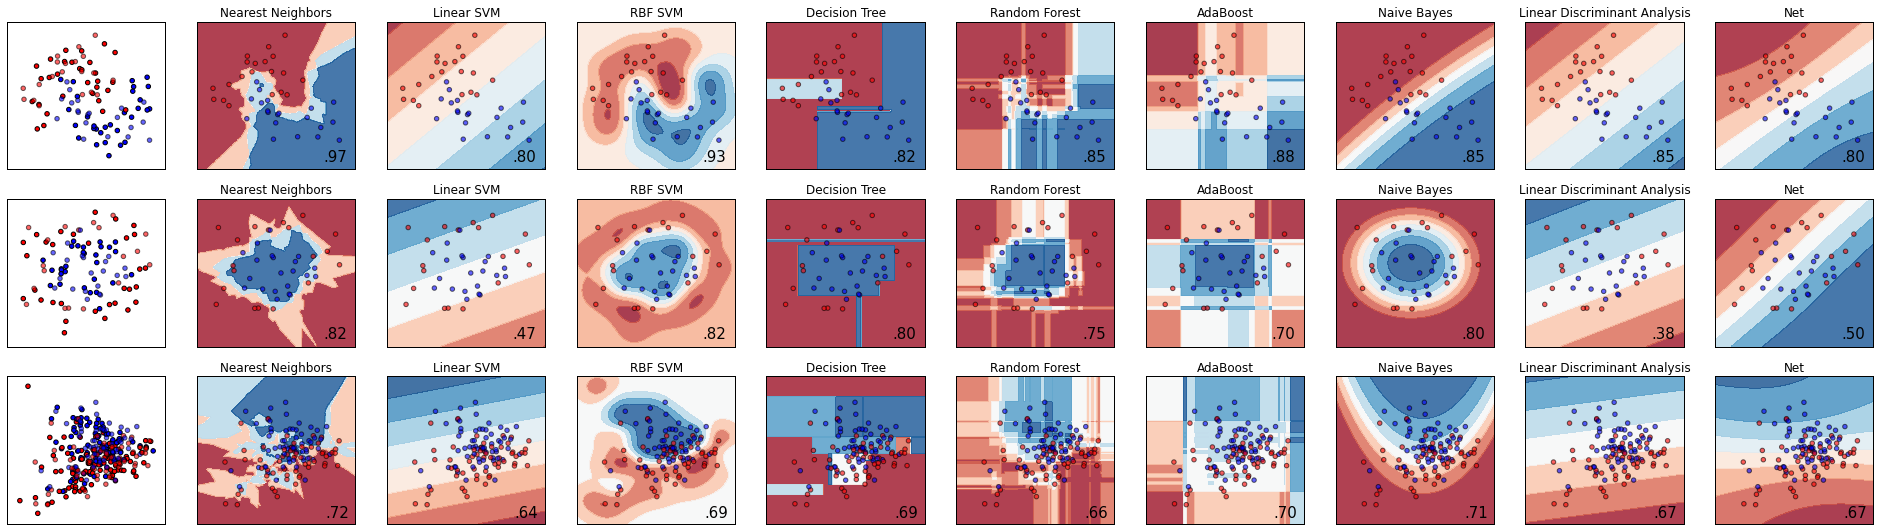

In [129]:
%matplotlib inline

#!/usr/bin/python
# -*- coding: utf-8 -*-

"""
=====================
Classifier comparison
=====================

A comparison of a several classifiers in scikit-learn on synthetic datasets.
The point of this example is to illustrate the nature of decision boundaries
of different classifiers.
This should be taken with a grain of salt, as the intuition conveyed by
these examples does not necessarily carry over to real datasets.

Particularly in high-dimensional spaces, data can more easily be separated
linearly and the simplicity of classifiers such as naive Bayes and linear SVMs
might lead to better generalization than is achieved by other classifiers.

The plots show training points in solid colors and testing points
semi-transparent. The lower right shows the classification accuracy on the test
set.
"""
print(__doc__)


# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

from matplotlib.colors import ListedColormap
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree",
         "Random Forest", "AdaBoost", "Naive Bayes", "Linear Discriminant Analysis",
         "Net"]
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    Classifier(
    layers=[
        Layer("Sigmoid", units=5, dropout = 0.4),
        Layer("Softmax")],
    learning_rate=0.04,
    n_iter=5, verbose = True),
]

X, y = img_per_area, trainVal[fullSet]

dss = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            dss
            ]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds in datasets:
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, m_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        #ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

figure.subplots_adjust(left=.02, right=.98)
plt.show()



Now we can run a deep learning model to see if we can get comparable (or better results).


In [64]:
from sknn.mlp import Classifier, Layer, Convolution
from sklearn import cross_validation

trainImg = trainImg.astype(np.float32)
trainInt = trainVal.astype(np.uint8)

trainImg = np.swapaxes(np.swapaxes(trainImg, 1, 2) , 2, 3)

print "Building Classifier:"
nn = Classifier(
    layers=[
        Convolution("Rectifier", channels=192, kernel_shape=(4,4), pool_shape = (2, 2)),
        Convolution("Rectifier", channels=128, kernel_shape=(6,6), pool_shape = (2, 2), dropout = 0.4),
        Layer("Rectifier", units=300, dropout = 0.4),
        Layer("Softmax")],
    learning_rate=0.001,
    n_iter=20, verbose = True)

print "Training Classifier: split"
X_train, X_test, y_train, y_test = cross_validation.train_test_split(trainImg[fullSet], trainInt[fullSet])
nn.fit(X_train, y_train)
score = nn.score(X_test, y_test)


Building Classifier:
Training Classifier: split
[(74, 2)]


0.945945945946
[(74, 2)]
Confusion matrix, without normalization
[[31  4]
 [ 0 39]]


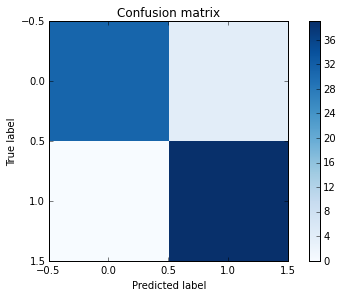

In [67]:
print score
y_pred = nn.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix, without normalization')
print(cm)
plt.figure()

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm)


Now we did classification with equal distributions of mitosis and normal images. Obviously this won't scale well to the actual problem, with a much more skewed set of data. Let's explore what probabilities the network assigns to each patch of the image being mitosis!

train/A04_02.bmp
no
(2084, 2084, 3)


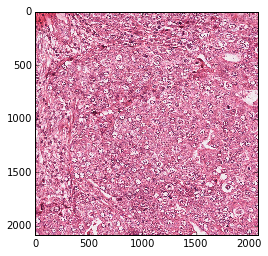

[[[239 100 129]
  [254 106 140]
  [254 106 140]
  ..., 
  [171  77 125]
  [172  78 126]
  [184  92 137]]

 [[234 101 128]
  [255 107 139]
  [255 107 139]
  ..., 
  [197 103 151]
  [198 104 152]
  [198 105 147]]

 [[222  90 121]
  [246 100 134]
  [249 103 137]
  ..., 
  [196 102 150]
  [198 104 152]
  [197 106 145]]

 ..., 
 [[246 249 242]
  [249 248 246]
  [243 242 240]
  ..., 
  [223 156 183]
  [201 134 161]
  [182 112 146]]

 [[247 241 243]
  [253 247 249]
  [249 243 245]
  ..., 
  [208 140 165]
  [201 133 158]
  [197 121 157]]

 [[248 226 236]
  [255 238 244]
  [251 234 240]
  ..., 
  [228 158 184]
  [226 156 182]
  [229 150 187]]]
[[[ 0.89803922  0.33725491  0.44313726]
  [ 0.93333334  0.37254903  0.47843137]
  [ 0.92941177  0.41568628  0.51764709]
  ..., 
  [ 0.67450982  0.24705882  0.36862746]
  [ 0.74117649  0.25882354  0.37254903]
  [ 0.75294119  0.27058825  0.38431373]]

 [[ 0.88235295  0.32549021  0.4509804 ]
  [ 0.9254902   0.36862746  0.49411765]
  [ 0.9254902   0.42352942 

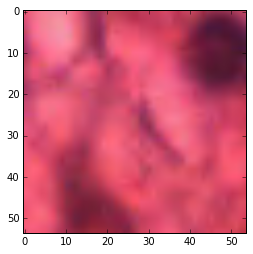

In [111]:
patch_probs = np.zeros((SIZE, SIZE))
imgFile = "train/A04_02.bmp"
print imgFile

try:
    img = Image.open(imageFile);
    img = img.load()
except:
    print "no"
    img = plt.imread(imgFile)
print img.shape
plt.imshow(img)
plt.show()

patch = np.zeros((1, PATCH_SIZE, PATCH_SIZE, 3))
patch = patch.astype(np.float32)

print img

for i in range(PATCH_SIZE, SIZE/30):
    for j in range(PATCH_SIZE, SIZE/30):
        sx = i - PATCH_SIZE/2
        sy = j - PATCH_SIZE/2
        for dx in range(0, PATCH_SIZE):
            for dy in range(0, PATCH_SIZE):
                patch[0, dx, dy, 0] = float(img[sx + dx, sy + dy, 0])/255
                patch[0, dx, dy, 1] = float(img[sx + dx, sy + dy, 1])/255
                patch[0, dx, dy, 2] = float(img[sx + dx, sy + dy, 2])/255
        plt.imshow(patch[0])
        print patch[0]
        plt.show()
        break
    break
plt.show()